load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...
Schedule found!



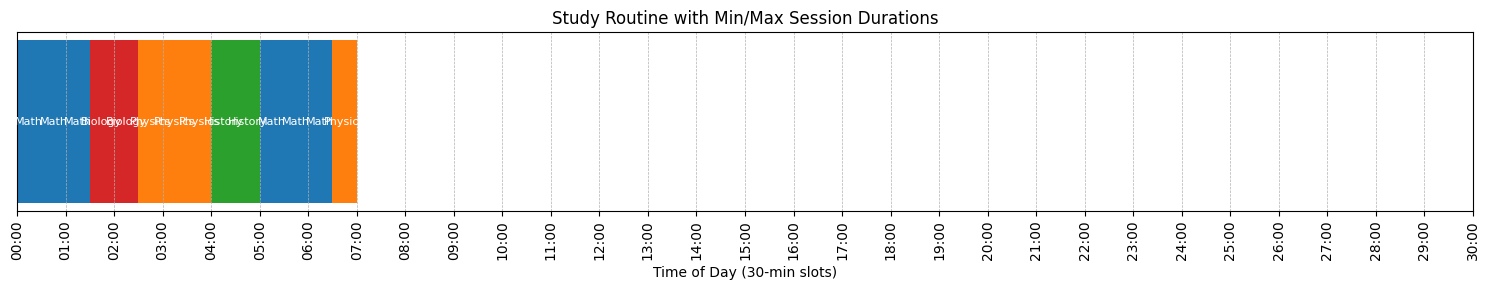

{'Math': [SubjectSession(start=Math_start_0(0..59), duration=Math_dur_0(1..2), interval=Math_interval_0(start = Math_start_0, size = Math_dur_0, end = Math_end_0, is_present = Math_active_0), is_present=Math_active_0(0..1)), SubjectSession(start=Math_start_1(0..59), duration=Math_dur_1(1..2), interval=Math_interval_1(start = Math_start_1, size = Math_dur_1, end = Math_end_1, is_present = Math_active_1), is_present=Math_active_1(0..1)), SubjectSession(start=Math_start_2(0..59), duration=Math_dur_2(1..2), interval=Math_interval_2(start = Math_start_2, size = Math_dur_2, end = Math_end_2, is_present = Math_active_2), is_present=Math_active_2(0..1)), SubjectSession(start=Math_start_3(0..59), duration=Math_dur_3(1..2), interval=Math_interval_3(start = Math_start_3, size = Math_dur_3, end = Math_end_3, is_present = Math_active_3), is_present=Math_active_3(0..1)), SubjectSession(start=Math_start_4(0..59), duration=Math_dur_4(1..2), interval=Math_interval_4(start = Math_start_4, size = Math_du

In [1]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import collections

# get the subject data with total credits
subjects_data = {
    'Math': 3,
    'Physics': 2,
    'History': 1,
    'Biology': 1
}

# calculation related to time split and total time per session

time_slot_minutes = 30
slots_per_hour = 60 // time_slot_minutes
day_duration_hours = 30
total_slots = day_duration_hours * slots_per_hour  

min_session_slots = 1  # 30 min
max_session_slots = 2  # 2 hours

# intializing the model
model = cp_model.CpModel()
all_subjects = list(subjects_data.keys())

SubjectSession = collections.namedtuple('SubjectSession', ['start', 'duration', 'interval', 'is_present'])


# creating the subject session
all_intervals = []
subject_sessions = {}

for subject in all_subjects:
    total_slots_needed = subjects_data[subject] * slots_per_hour # Total subjects per day per credits
    max_possible_sessions = total_slots_needed  # worst case: 30-min chunks

    sessions = []
    for i in range(max_possible_sessions):
        start = model.NewIntVar(0, total_slots - 1, f'{subject}_start_{i}')
        duration = model.NewIntVar(min_session_slots, max_session_slots, f'{subject}_dur_{i}')
        end = model.NewIntVar(0, total_slots, f'{subject}_end_{i}')
        is_present = model.NewBoolVar(f'{subject}_active_{i}')
        interval = model.NewOptionalIntervalVar(start, duration, end, is_present, f'{subject}_interval_{i}')
        sessions.append(SubjectSession(start, duration, interval, is_present))
        all_intervals.append(interval)
    subject_sessions[subject] = sessions

# all the constraints

# Ensure total time per subject is respected
for subject in all_subjects:
    sessions = subject_sessions[subject]
    active_durations = []
    for s in sessions:
        active = s.is_present
        active_durations.append(model.NewIntVar(0, max_session_slots, f'{subject}_active_dur'))
        model.Add(s.duration == active_durations[-1]).OnlyEnforceIf(active)
        model.Add(s.duration == 0).OnlyEnforceIf(active.Not())

    model.Add(sum(active_durations) == subjects_data[subject] * slots_per_hour)

# No overlapping sessions across all subjects
model.AddNoOverlap(all_intervals)

# No consecutive sessions of the same subject
for subject in all_subjects:
    sessions = subject_sessions[subject]
    for i in range(len(sessions)):
        for j in range(i + 1, len(sessions)):
            si, sj = sessions[i], sessions[j]
            active_both = model.NewBoolVar(f'{subject}_adj_{i}_{j}')
            model.AddBoolAnd([si.is_present, sj.is_present]).OnlyEnforceIf(active_both)
            model.AddBoolOr([si.is_present.Not(), sj.is_present.Not()]).OnlyEnforceIf(active_both.Not())
            # Add no direct adjacency
            model.Add(si.start + si.duration != sj.start).OnlyEnforceIf(active_both)

# constrain remain : skip the classes time, maximum gap between each session 


# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
status = solver.Solve(model)

# ---------------------------
# Visualization
# ---------------------------
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    print('Schedule found!\n')
    fig, ax = plt.subplots(figsize=(15, 3))
    subject_colors = {s: f'C{i}' for i, s in enumerate(all_subjects)}
    y_pos = 5

    for subject in all_subjects:
        for s in subject_sessions[subject]:
            if solver.Value(s.is_present):
                start = solver.Value(s.start)
                duration = solver.Value(s.duration)
                ax.broken_barh([(start, duration)], (y_pos, 4), facecolors=subject_colors[subject])
                ax.text(start + duration / 2, y_pos + 2, subject, ha='center', va='center', color='white', fontsize=8)

    ax.set_xlim(0, total_slots)
    ax.set_xticks(range(0, total_slots + 1, 2))
    ax.set_xticklabels([f'{(i * time_slot_minutes) // 60:02}:{(i * time_slot_minutes) % 60:02}' for i in range(0, total_slots + 1, 2)], rotation=90)
    ax.set_yticks([])
    ax.set_title('Study Routine with Min/Max Session Durations')
    ax.set_xlabel('Time of Day (30-min slots)')
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print('No solution found.')
print(subject_sessions)


In [2]:
from ortools.sat.python import cp_model
from datetime import datetime, timedelta
import pandas as pd

class WeeklyScheduler:
    def __init__(self):
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        
        # Time slots (in 30-minute intervals from 6:00 to 20:30)
        self.time_slots = []
        start_time = 6 * 60  # 6:00 AM in minutes
        end_time = 20 * 60 + 30  # 8:30 PM in minutes
        for t in range(start_time, end_time, 30):
            hours = t // 60
            minutes = t % 60
            self.time_slots.append(f"{hours:02d}:{minutes:02d}")
        
        # Days of the week
        self.days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        # Subjects with their credits (determines study session allocation)
        self.subjects = {
            'MATH_208': {'credits': 3, 'color': '#FFB366'},  # Orange
            'ENG_111': {'credits': 2, 'color': '#87CEEB'},   # Light Blue
            'MATH_207': {'credits': 3, 'color': '#90EE90'},  # Light Green
            'COMP_202': {'credits': 4, 'color': '#F0E68C'},  # Khaki
            'COMP_204': {'credits': 3, 'color': '#DDA0DD'}   # Plum
        }
        
        # Fixed class times (day_index, start_slot, duration_slots, subject)
        self.fixed_classes = [
            # Monday
            (0, self.time_to_slot("9:00"), self.duration_to_slots(7, 0), "CLASS_TIME"),  # 9:00-16:00
            (0, self.time_to_slot("18:00"), self.duration_to_slots(1, 0), "COMP_202"),   # 18:00-19:00
            (0, self.time_to_slot("19:30"), self.duration_to_slots(1, 0), "COMP_204"),   # 19:30-20:30
            
            # Tuesday  
            (1, self.time_to_slot("9:00"), self.duration_to_slots(7, 0), "CLASS_TIME"),  # 9:00-16:00
            (1, self.time_to_slot("17:00"), self.duration_to_slots(1, 0), "COMP_202"),   # 17:00-18:00
            
            # Wednesday
            (2, self.time_to_slot("9:00"), self.duration_to_slots(7, 0), "CLASS_TIME"),  # 9:00-16:00
            
            # Thursday
            (3, self.time_to_slot("9:00"), self.duration_to_slots(7, 0), "CLASS_TIME"),  # 9:00-16:00
            (3, self.time_to_slot("18:00"), self.duration_to_slots(1, 0), "COMP_202"),   # 18:00-19:00
            (3, self.time_to_slot("19:30"), self.duration_to_slots(1, 0), "COMP_204"),   # 19:30-20:30
            
            # Friday
            (4, self.time_to_slot("9:00"), self.duration_to_slots(7, 0), "CLASS_TIME"),  # 9:00-16:00
            
            # Saturday
            # (5, self.time_to_slot("9:00"), self.duration_to_slots(4, 0), "CLASS_TIME"),  # 9:00-13:00
            
            # Sunday
            (6, self.time_to_slot("9:00"), self.duration_to_slots(4, 0), "CLASS_TIME"),  # 9:00-13:00
        ]
        
        # Decision variables for study sessions
        self.study_sessions = {}
        self.initialize_variables()
        
    def time_to_slot(self, time_str):
        """Convert time string to slot index"""
        hours, minutes = map(int, time_str.split(':'))
        time_minutes = hours * 60 + minutes
        start_minutes = 6 * 60  # 6:00 AM
        return (time_minutes - start_minutes) // 30
    
    def duration_to_slots(self, hours, minutes=0):
        """Convert duration to number of slots"""
        return (hours * 60 + minutes) // 30
    
    def slot_to_time(self, slot):
        """Convert slot index back to time string"""
        return self.time_slots[slot]
    
    def initialize_variables(self):
        """Initialize decision variables for study sessions"""
        for subject in self.subjects:
            self.study_sessions[subject] = {}
            for day_idx, day in enumerate(self.days):
                self.study_sessions[subject][day_idx] = {}
                for slot in range(len(self.time_slots)):
                    # Binary variable: 1 if subject has study session at this day/time
                    var_name = f"{subject}_{day}_{slot}"
                    self.study_sessions[subject][day_idx][slot] = self.model.NewBoolVar(var_name)
    
    def add_constraints(self):
        """Add scheduling constraints"""
        
        # 1. No overlapping sessions at any time slot
        for day_idx in range(len(self.days)):
            for slot in range(len(self.time_slots)):
                subjects_at_slot = []
                
                # Add study sessions
                for subject in self.subjects:
                    subjects_at_slot.append(self.study_sessions[subject][day_idx][slot])
                
                # Only one session per time slot
                self.model.Add(sum(subjects_at_slot) <= 1)
        
        # 2. Block fixed class times
        for day_idx, start_slot, duration, class_type in self.fixed_classes:
            for slot_offset in range(duration):
                current_slot = start_slot + slot_offset
                if current_slot < len(self.time_slots):
                    # No study sessions during fixed class times
                    for subject in self.subjects:
                        self.model.Add(self.study_sessions[subject][day_idx][current_slot] == 0)
        
        # 3. Credit-based study session allocation
        total_weekly_slots = len(self.days) * len(self.time_slots)
        
        for subject, info in self.subjects.items():
            # Calculate minimum sessions based on credits
            min_sessions = info['credits'] * 2  # 2 sessions per credit per week
            max_sessions = info['credits'] * 4  # Maximum sessions per week
            
            total_subject_sessions = []
            for day_idx in range(len(self.days)):
                for slot in range(len(self.time_slots)):
                    total_subject_sessions.append(self.study_sessions[subject][day_idx][slot])
            
            self.model.Add(sum(total_subject_sessions) >= min_sessions)
            self.model.Add(sum(total_subject_sessions) <= max_sessions)
        
        # 4. Session continuity (prefer 1-2 hour blocks)
        for subject in self.subjects:
            for day_idx in range(len(self.days)):
                for slot in range(len(self.time_slots) - 1):
                    # If session starts, encourage it to continue for at least 1 hour
                    current_session = self.study_sessions[subject][day_idx][slot]
                    next_session = self.study_sessions[subject][day_idx][slot + 1]
                    
                    # Soft constraint: if we start a session, prefer to continue it
                    continuation_var = self.model.NewBoolVar(f"continue_{subject}_{day_idx}_{slot}")
                    self.model.Add(next_session >= current_session - continuation_var)
        
        # 5. Daily limits per subject (max 3 hours per day per subject)
        for subject in self.subjects:
            for day_idx in range(len(self.days)):
                daily_sessions = []
                for slot in range(len(self.time_slots)):
                    daily_sessions.append(self.study_sessions[subject][day_idx][slot])
                self.model.Add(sum(daily_sessions) <= 6)  # 6 slots = 3 hours
        
        # 6. Early morning and late evening preferences
        for subject in self.subjects:
            for day_idx in range(len(self.days)):
                # Discourage very early (6:00-7:00) and very late (after 20:00) sessions
                early_slots = range(0, 2)  # 6:00-7:00
                late_slots = range(28, len(self.time_slots))  # after 20:00
                
                early_sessions = []
                late_sessions = []
                
                for slot in early_slots:
                    if slot < len(self.time_slots):
                        early_sessions.append(self.study_sessions[subject][day_idx][slot])
                
                for slot in late_slots:
                    if slot < len(self.time_slots):
                        late_sessions.append(self.study_sessions[subject][day_idx][slot])
                
                # Limit early and late sessions
                if early_sessions:
                    self.model.Add(sum(early_sessions) <= 1)
                if late_sessions:
                    self.model.Add(sum(late_sessions) <= 1)
    
    def set_objective(self):
        """Set optimization objective"""
        objective_terms = []
        
        # Maximize study sessions during preferred hours (8:00-18:00)
        preferred_start = self.time_to_slot("8:00")
        preferred_end = self.time_to_slot("18:00")
        
        for subject in self.subjects:
            for day_idx in range(len(self.days)):
                for slot in range(preferred_start, min(preferred_end, len(self.time_slots))):
                    objective_terms.append(self.study_sessions[subject][day_idx][slot] * 10)
        
        # Bonus for session continuity
        for subject in self.subjects:
            for day_idx in range(len(self.days)):
                for slot in range(len(self.time_slots) - 1):
                    current = self.study_sessions[subject][day_idx][slot]
                    next_slot = self.study_sessions[subject][day_idx][slot + 1]
                    
                    # Bonus when sessions are consecutive
                    continuation_bonus = self.model.NewBoolVar(f"bonus_{subject}_{day_idx}_{slot}")
                    self.model.Add(continuation_bonus <= current)
                    self.model.Add(continuation_bonus <= next_slot)
                    self.model.Add(continuation_bonus >= current + next_slot - 1)
                    
                    objective_terms.append(continuation_bonus * 5)
        
        self.model.Maximize(sum(objective_terms))
    
    def solve(self):
        """Solve the scheduling problem"""
        self.add_constraints()
        self.set_objective()
        
        # Set solver parameters
        self.solver.parameters.max_time_in_seconds = 30.0
        
        status = self.solver.Solve(self.model)
        
        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            return self.extract_schedule()
        else:
            return None
    
    def extract_schedule(self):
        """Extract the solution into a readable format"""
        schedule = {}
        
        for day_idx, day in enumerate(self.days):
            schedule[day] = {}
            
            # Add fixed classes first
            for fix_day_idx, start_slot, duration, class_type in self.fixed_classes:
                if fix_day_idx == day_idx:
                    for slot_offset in range(duration):
                        current_slot = start_slot + slot_offset
                        if current_slot < len(self.time_slots):
                            time_str = self.slot_to_time(current_slot)
                            if class_type == "CLASS_TIME":
                                schedule[day][time_str] = {
                                    'subject': 'Class Time',
                                    'type': 'fixed',
                                    'color': '#FFB6C1'  # Light pink
                                }
                            else:
                                schedule[day][time_str] = {
                                    'subject': class_type,
                                    'type': 'fixed',
                                    'color': self.subjects[class_type]['color']
                                }
            
            # Add study sessions
            for subject in self.subjects:
                for slot in range(len(self.time_slots)):
                    if self.solver.Value(self.study_sessions[subject][day_idx][slot]):
                        time_str = self.slot_to_time(slot)
                        schedule[day][time_str] = {
                            'subject': subject,
                            'type': 'study',
                            'color': self.subjects[subject]['color']
                        }
        
        return schedule
    
    def print_schedule(self, schedule):
        """Print the schedule in a readable format"""
        if not schedule:
            print("No feasible schedule found!")
            return
        
        print("\n" + "="*80)
        print("WEEKLY CLASS SCHEDULE")
        print("="*80)
        
        for day in self.days:
            print(f"\n{day.upper()}")
            print("-" * 40)
            
            day_schedule = schedule.get(day, {})
            if not day_schedule:
                print("  No scheduled activities")
                continue
            
            # Sort by time
            sorted_times = sorted(day_schedule.keys(), key=lambda x: self.time_to_slot(x))
            
            current_block = None
            block_start = None
            
            for time_str in sorted_times:
                session = day_schedule[time_str]
                
                if current_block != session['subject']:
                    # Print previous block if exists
                    if current_block:
                        print(f"  {block_start} - {prev_time}: {current_block} ({prev_type})")
                    
                    # Start new block
                    current_block = session['subject']
                    block_start = time_str
                    prev_type = session['type']
                
                prev_time = time_str
            
            # Print last block
            if current_block:
                # Calculate end time (add 30 minutes)
                end_slot = self.time_to_slot(prev_time) + 1
                if end_slot < len(self.time_slots):
                    end_time = self.slot_to_time(end_slot)
                else:
                    end_time = "20:30"
                print(f"  {block_start} - {end_time}: {current_block} ({prev_type})")
        
        # Print statistics
        self.print_statistics(schedule)
    
    def print_statistics(self, schedule):
        """Print scheduling statistics"""
        print("\n" + "="*50)
        print("SCHEDULE STATISTICS")
        print("="*50)
        
        subject_hours = {subject: 0 for subject in self.subjects}
        
        for day in schedule:
            for time_str, session in schedule[day].items():
                if session['type'] == 'study' and session['subject'] in subject_hours:
                    subject_hours[session['subject']] += 0.5  # Each slot is 30 minutes
        
        print("\nWeekly Study Hours by Subject:")
        for subject, hours in subject_hours.items():
            credits = self.subjects[subject]['credits']
            print(f"  {subject}: {hours:.1f} hours (Credits: {credits})")
        
        total_study_hours = sum(subject_hours.values())
        print(f"\nTotal Weekly Study Hours: {total_study_hours:.1f}")

# Example usage
def main():
    print("Creating Weekly Class Schedule...")
    scheduler = WeeklyScheduler()
    
    print("Solving optimization problem...")
    schedule = scheduler.solve()
    
    if schedule:
        scheduler.print_schedule(schedule)
        
        # Also return the schedule for potential GUI display
        return schedule
    else:
        print("Could not find a feasible schedule. Try adjusting constraints.")
        return None

if __name__ == "__main__":
    schedule = main()

Creating Weekly Class Schedule...
Solving optimization problem...

WEEKLY CLASS SCHEDULE

MONDAY
----------------------------------------
  08:00 - 08:30: COMP_202 (study)
  09:00 - 15:30: Class Time (fixed)
  16:00 - 17:30: MATH_207 (study)
  18:00 - 18:30: COMP_202 (fixed)
  19:30 - 20:30: COMP_204 (fixed)

TUESDAY
----------------------------------------
  08:00 - 08:30: COMP_204 (study)
  09:00 - 15:30: Class Time (fixed)
  16:00 - 16:30: MATH_207 (study)
  17:00 - 18:00: COMP_202 (fixed)

WEDNESDAY
----------------------------------------
  08:00 - 08:30: ENG_111 (study)
  09:00 - 15:30: Class Time (fixed)
  16:00 - 18:00: MATH_207 (study)

THURSDAY
----------------------------------------
  08:00 - 08:30: COMP_202 (study)
  09:00 - 15:30: Class Time (fixed)
  16:00 - 17:30: COMP_204 (study)
  18:00 - 18:30: COMP_202 (fixed)
  19:30 - 20:30: COMP_204 (fixed)

FRIDAY
----------------------------------------
  08:00 - 08:30: COMP_202 (study)
  09:00 - 15:30: Class Time (fixed)
  16:

In [3]:
from ortools.sat.python import cp_model
from datetime import datetime, timedelta
import pandas as pd

class WeeklyScheduler:
    def __init__(self):
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        
        # Define time slots (in 30-minute intervals from 6:00 to 22:00)
        self.start_hour = 6
        self.end_hour = 22
        self.time_slots = list(range(0, (self.end_hour - self.start_hour) * 2))  # 32 slots
        
        # Days of the week
        self.days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        # Subjects with their credit hours (determines study session allocation)
        self.subjects = {
            'MATH 208': {'credits': 3, 'color': 'orange'},
            'ENG 111': {'credits': 3, 'color': 'lightblue'},
            'MATH 207': {'credits': 3, 'color': 'lightgreen'},
            'COMP 202': {'credits': 3, 'color': 'yellow'},
            'COMP 204': {'credits': 2, 'color': 'lightpink'}
        }
        
        # Fixed class times (time_slot, day_index)
        # Time slot 0 = 6:00-6:30, 1 = 6:30-7:00, etc.
        self.fixed_classes = {
            # Monday
            ('Monday', 0, 1): 'ENG 111',    # 6:00-7:00
            ('Monday', 4, 5): 'MATH 208',   # 8:00-9:00
            ('Monday', 6, 13): 'Class Time', # 9:00-16:00 (fixed class time)
            ('Monday', 24, 25): 'COMP 202', # 18:00-19:00
            ('Monday', 26, 27): 'COMP 204', # 19:00-20:00
            
            # Tuesday
            ('Tuesday', 0, 1): 'MATH 207',   # 6:00-7:00
            ('Tuesday', 6, 13): 'Class Time', # 9:00-16:00 (fixed class time)
            ('Tuesday', 22, 23): 'COMP 202', # 17:00-18:00
            
            # Wednesday
            ('Wednesday', 0, 1): 'MATH 208', # 6:00-7:00
            ('Wednesday', 2, 3): 'ENG 111',  # 7:00-8:00
            ('Wednesday', 6, 13): 'Class Time', # 9:00-16:00 (fixed class time)
            ('Wednesday', 22, 23): 'MATH 207', # 17:00-18:00
            ('Wednesday', 24, 25): 'COMP 202', # 18:00-19:00
            ('Wednesday', 26, 27): 'COMP 204', # 19:00-20:00
            
            # Add more days as needed...
        }
        
        # Variables for scheduling study sessions
        self.schedule_vars = {}
        
    def time_slot_to_string(self, slot):
        """Convert time slot number to readable time string"""
        hour = self.start_hour + slot // 2
        minute = 30 if slot % 2 == 1 else 0
        return f"{hour:02d}:{minute:02d}"
    
    def create_variables(self):
        """Create decision variables for study sessions"""
        for day in self.days:
            for subject in self.subjects:
                for slot in self.time_slots:
                    var_name = f"{subject}_{day}_{slot}"
                    self.schedule_vars[(subject, day, slot)] = self.model.NewBoolVar(var_name)
    
    def add_constraints(self):
        """Add scheduling constraints"""
        
        # 1. Credit-based study session allocation
        for subject, info in self.subjects.items():
            # Each subject should have study sessions proportional to credits
            # Minimum 2 sessions per week per credit
            min_sessions = info['credits'] * 2
            total_sessions = []
            for day in self.days:
                for slot in self.time_slots:
                    if (subject, day, slot) in self.schedule_vars:
                        total_sessions.append(self.schedule_vars[(subject, day, slot)])
            
            if total_sessions:
                self.model.Add(sum(total_sessions) >= min_sessions)
                # Maximum sessions to prevent over-allocation
                self.model.Add(sum(total_sessions) <= min_sessions + 2)
        
        # 2. No overlapping sessions
        for day in self.days:
            for slot in self.time_slots:
                # Only one subject can be scheduled per time slot
                slot_vars = []
                for subject in self.subjects:
                    if (subject, day, slot) in self.schedule_vars:
                        slot_vars.append(self.schedule_vars[(subject, day, slot)])
                
                if slot_vars:
                    self.model.Add(sum(slot_vars) <= 1)
        
        # 3. Avoid scheduling during fixed class times
        for day in self.days:
            for slot in self.time_slots:
                # Check if this slot conflicts with fixed classes
                is_blocked = False
                for (fixed_day, start_slot, end_slot), class_name in self.fixed_classes.items():
                    if day == fixed_day and start_slot <= slot <= end_slot:
                        is_blocked = True
                        break
                
                if is_blocked:
                    for subject in self.subjects:
                        if (subject, day, slot) in self.schedule_vars:
                            self.model.Add(self.schedule_vars[(subject, day, slot)] == 0)
        
        # 4. Minimum gap between study sessions of same subject
        for subject in self.subjects:
            for day in self.days:
                for slot in range(len(self.time_slots) - 2):  # Ensure minimum 1-hour gap
                    if ((subject, day, slot) in self.schedule_vars and 
                        (subject, day, slot + 1) in self.schedule_vars):
                        self.model.Add(
                            self.schedule_vars[(subject, day, slot)] + 
                            self.schedule_vars[(subject, day, slot + 1)] <= 1
                        )
        
        # 5. Balanced daily distribution
        for day in self.days:
            daily_sessions = []
            for subject in self.subjects:
                for slot in self.time_slots:
                    if (subject, day, slot) in self.schedule_vars:
                        daily_sessions.append(self.schedule_vars[(subject, day, slot)])
            
            if daily_sessions:
                # Limit daily study sessions (max 6 sessions per day)
                self.model.Add(sum(daily_sessions) <= 6)
                # Ensure minimum sessions per day (at least 1)
                self.model.Add(sum(daily_sessions) >= 1)
    
    def solve_schedule(self):
        """Solve the scheduling problem"""
        self.create_variables()
        self.add_constraints()
        
        # Solve
        status = self.solver.Solve(self.model)
        
        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            return self.extract_solution()
        else:
            return None
    
    def extract_solution(self):
        """Extract the solution into a readable format"""
        schedule = {}
        
        # Initialize schedule structure
        for day in self.days:
            schedule[day] = {}
            for slot in self.time_slots:
                time_str = self.time_slot_to_string(slot)
                schedule[day][time_str] = None
        
        # Add fixed classes
        for (day, start_slot, end_slot), class_name in self.fixed_classes.items():
            start_time = self.time_slot_to_string(start_slot)
            end_time = self.time_slot_to_string(end_slot + 1)
            schedule[day][f"{start_time}-{end_time}"] = {
                'subject': class_name,
                'type': 'fixed',
                'color': 'lightcoral' if class_name == 'Class Time' else self.subjects.get(class_name, {}).get('color', 'gray')
            }
        
        # Add scheduled study sessions
        for (subject, day, slot), var in self.schedule_vars.items():
            if self.solver.Value(var) == 1:
                time_str = self.time_slot_to_string(slot)
                end_time = self.time_slot_to_string(slot + 1)
                schedule[day][f"{time_str}-{end_time}"] = {
                    'subject': subject,
                    'type': 'study',
                    'color': self.subjects[subject]['color']
                }
        
        return schedule
    
    def print_schedule(self, schedule):
        """Print the schedule in a readable format"""
        if not schedule:
            print("No feasible schedule found!")
            return
        
        print("\n" + "="*80)
        print("WEEKLY STUDY SCHEDULE")
        print("="*80)
        
        for day in self.days:
            print(f"\n{day.upper()}:")
            print("-" * 40)
            
            # Sort time slots
            day_schedule = schedule[day]
            sorted_times = sorted([k for k in day_schedule.keys() if day_schedule[k] is not None])
            
            for time_slot in sorted_times:
                session = day_schedule[time_slot]
                session_type = session['type'].upper()
                print(f"  {time_slot}: {session['subject']} ({session_type})")
            
            if not sorted_times:
                print("  No sessions scheduled")
    
    def export_to_dataframe(self, schedule):
        """Export schedule to pandas DataFrame for further analysis"""
        data = []
        
        for day in self.days:
            for time_slot, session in schedule[day].items():
                if session:
                    data.append({
                        'Day': day,
                        'Time': time_slot,
                        'Subject': session['subject'],
                        'Type': session['type'],
                        'Color': session['color']
                    })
        
        return pd.DataFrame(data)

# Example usage
if __name__ == "__main__":
    scheduler = WeeklyScheduler()
    
    print("Creating weekly study schedule...")
    print("Subjects and credits:")
    for subject, info in scheduler.subjects.items():
        print(f"  {subject}: {info['credits']} credits")
    
    # Solve the scheduling problem
    schedule = scheduler.solve_schedule()
    
    if schedule:
        # Print the schedule
        scheduler.print_schedule(schedule)
        
        # Export to DataFrame
        df = scheduler.export_to_dataframe(schedule)
        print(f"\nTotal scheduled sessions: {len(df)}")
        print("\nSession distribution by subject:")
        print(df.groupby('Subject').size().sort_values(ascending=False))
        
        # Save to CSV
        df.to_csv('weekly_schedule.csv', index=False)
        print("\nSchedule exported to 'weekly_schedule.csv'")
        
    else:
        print("Could not find a feasible schedule. Try adjusting constraints.")

Creating weekly study schedule...
Subjects and credits:
  MATH 208: 3 credits
  ENG 111: 3 credits
  MATH 207: 3 credits
  COMP 202: 3 credits
  COMP 204: 2 credits

WEEKLY STUDY SCHEDULE

MONDAY:
----------------------------------------
  06:00-07:00: ENG 111 (FIXED)
  08:00-09:00: MATH 208 (FIXED)
  09:00-13:00: Class Time (FIXED)
  16:30-17:00: COMP 204 (STUDY)
  18:00-19:00: COMP 202 (FIXED)
  19:00-20:00: COMP 204 (FIXED)
  21:00-21:30: COMP 202 (STUDY)

TUESDAY:
----------------------------------------
  06:00-07:00: MATH 207 (FIXED)
  09:00-13:00: Class Time (FIXED)
  15:00-15:30: MATH 208 (STUDY)
  17:00-18:00: COMP 202 (FIXED)
  20:00-20:30: MATH 207 (STUDY)

WEDNESDAY:
----------------------------------------
  06:00-07:00: MATH 208 (FIXED)
  07:00-08:00: ENG 111 (FIXED)
  09:00-13:00: Class Time (FIXED)
  13:30-14:00: COMP 204 (STUDY)
  17:00-18:00: MATH 207 (FIXED)
  18:00-19:00: COMP 202 (FIXED)
  19:00-20:00: COMP 204 (FIXED)

THURSDAY:
-----------------------------------